In [6]:
import numpy as np

from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
import numpy.matlib
import matplotlib.pyplot as plt
from matplotlib import cm
import tensorflow as tf
from tensorflow import keras
import time
from IPython import display

#%%  structural FE
class StructuralFE:

    def __init__(self, nelx,nely):
        self.nely, self.nelx = nely,nelx
        self.nele = nelx*nely
        self.penal = 2.0


    def getDMatrix(self):
        E=1
        nu=0.3
        k=np.array([1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,-1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8])
        KE = E/(1-nu**2)*np.array([ [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
        [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
        [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
        [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
        [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
        [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
        [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
        [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]] ]);
        return (KE);
    #-----------------------#
    def initializeSolver(self, force, fixed, Emin = 1e-3, Emax = 1.0):
        self.Emin = Emin;
        self.Emax = Emax;
        self.ndof = 2*(self.nelx+1)*(self.nely+1)
        self.KE=self.getDMatrix();
        dofs=np.arange(self.ndof);
        self.fixed = fixed
        self.free = np.setdiff1d(np.arange(self.ndof),self.fixed);
        self.f = force;

        self.edofMat=np.zeros((self.nelx*self.nely,8),dtype=int)
        for elx in range(self.nelx):
            for ely in range(self.nely):
                el = ely+elx*self.nely
                n1=(self.nely+1)*elx+ely
                n2=(self.nely+1)*(elx+1)+ely
                self.edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3,2*n2, 2*n2+1, 2*n1, 2*n1+1])

        self.iK = np.kron(self.edofMat,np.ones((8,1))).flatten()
        self.jK = np.kron(self.edofMat,np.ones((1,8))).flatten()

    #-----------------------#
    @tf.custom_gradient
    def compliance(self, density):
        
        density = np.reshape(tf.transpose(density),[1,-1])
        self.u=np.zeros((self.ndof,1))
        # solve
        sK=((self.KE.flatten()[np.newaxis]).T*(self.Emin+(0.01 + density)**self.penal*(self.Emax-self.Emin))).flatten(order='F')
        K = coo_matrix((sK,(self.iK,self.jK)),shape=(self.ndof,self.ndof)).tocsc()
        K = K[self.free,:][:,self.free]
        self.u[self.free,0]=spsolve(K,self.f[self.free,0])
        Ei = self.Emin + density**self.penal*(self.Emax-self.Emin)
        ce = (np.dot(self.u[self.edofMat].reshape(self.nelx*self.nely,8),self.KE) * self.u[self.edofMat].reshape(self.nelx*self.nely,8) ).sum(1)
        c = np.sum(Ei*ce)
        c = tf.convert_to_tensor(c, dtype=tf.float32)
        def grad(dy):
            dc = -dy* self.penal*density**(self.penal - 1.0)*ce
            dc = tf.convert_to_tensor(dc,dtype = tf.float32)
            return tf.reshape(dc,[-1,1])
        return c, grad;

    def strain_energy(self, density,penal):
        
        density = np.reshape(tf.transpose(density),[1,-1])
        self.u=np.zeros((self.ndof,1))
        # solve
        sK=((self.KE.flatten()[np.newaxis]).T*(self.Emin+(0.01 + density)**self.penal*(self.Emax-self.Emin))).flatten(order='F')
        K = coo_matrix((sK,(self.iK,self.jK)),shape=(self.ndof,self.ndof)).tocsc()
        K = K[self.free,:][:,self.free]
        self.u[self.free,0]=spsolve(K,self.f[self.free,0])
        Ei = self.Emin + density**penal*(self.Emax-self.Emin)
        ce = (np.dot(self.u[self.edofMat].reshape(self.nelx*self.nely,8),self.KE) * self.u[self.edofMat].reshape(self.nelx*self.nely,8) ).sum(1)

        return ce

class Problems():
    def __init__(self) -> None:
        pass

class Cantilever_Beam_End_Points_Loads_2D(Problems):
    def __init__(self,nelx,nely, xid, yid, vf):


        self.nelx = nelx; # number of FE elements along X
        self.nely = nely; # number of FE elements along Y
        self.nele = self.nelx*self.nely

        self.xid = xid
        self.yid = yid
        self.penal = 2.0
        self.Emin = 1e-6
        self.Emax = 1
        self.nelm = max(self.nelx,self.nely)
        self.volfrac = vf

        self.penal_init = 2.0
        self.penal_max = 4.0
        self.penal_delta = 0.005

        self.alpha_init = 1
        self.alpha_max = 100
        self.alpha_delta = 0.25

        c_x, c_y=np.meshgrid(np.linspace(-(self.nelx-1)/(2*self.nelm),(self.nelx-1)/(2*self.nelm),self.nelx),
                                                np.linspace(-(self.nely-1)/(2*self.nelm),(self.nely-1)/(2*self.nelm),self.nely),indexing='ij')
        self.dlX = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 1).reshape([-1,2])

        self.dlX = tf.convert_to_tensor(self.dlX, dtype = tf.float32)
        self.force_voxel = np.zeros((self.nelx,self.nely)) #same order as you plot out using inshow
        self.force_voxel[xid,yid] = -1

        self.filter = tf.reshape(tf.ones([self.nelx,self.nely]),[-1,1])

class Clover(Problems):
    def __init__(self, vf):


        self.nelx = 60; # number of FE elements along X
        self.nely = 60; # number of FE elements along Y
        self.nele = self.nelx*self.nely


        self.penal = 2.0
        self.Emin = 1e-6
        self.Emax = 1
        self.nelm = max(self.nelx,self.nely)
        self.volfrac = vf

        self.penal_init = 2.0
        self.penal_max = 4.0
        self.penal_delta = 0.005

        self.alpha_init = 1
        self.alpha_max = 100
        self.alpha_delta = 0.25

        c_x, c_y=np.meshgrid(np.linspace(-(self.nelx-1)/(2*self.nelm),(self.nelx-1)/(2*self.nelm),self.nelx),
                                                np.linspace(-(self.nely-1)/(2*self.nelm),(self.nely-1)/(2*self.nelm),self.nely),indexing='ij')
        self.dlX = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 1).reshape([-1,2])

        self.dlX = tf.convert_to_tensor(self.dlX, dtype = tf.float32)
 
        ndof = 2*(self.nelx+1)*(self.nely+1)
        self.force = np.zeros((ndof,1))
        self.force[61] = 1.0
        self.force[7381] = -1.0
        self.force[3780] = -1.0
        self.force[3660] = 1.0
    
        dofs=np.arange(ndof);
        self.fixed = np.array([2500,2501,5062,5063])

        self.filter = tf.reshape(tf.ones([self.nelx,self.nely]),[-1,1])

class CloverScaling(Problems):
    def __init__(self,nelx,nely, vf):


        self.nelx = nelx; # number of FE elements along X
        self.nely = nely; # number of FE elements along Y
        self.nele = self.nelx*self.nely


        self.penal = 2.0
        self.Emin = 1e-6
        self.Emax = 1
        self.nelm = max(self.nelx,self.nely)
        self.volfrac = vf

        self.penal_init = 2.0
        self.penal_max = 4.0
        self.penal_delta = 0.005

        self.alpha_init = 1
        self.alpha_max = 100
        self.alpha_delta = 0.25

        c_x, c_y=np.meshgrid(np.linspace(-(self.nelx-1)/(2*self.nelm),(self.nelx-1)/(2*self.nelm),self.nelx),
                                                np.linspace(-(self.nely-1)/(2*self.nelm),(self.nely-1)/(2*self.nelm),self.nely),indexing='ij')
        self.dlX = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 1).reshape([-1,2])

        self.dlX = tf.convert_to_tensor(self.dlX, dtype = tf.float32)
 
        ndof = 2*(self.nelx+1)*(self.nely+1)
        self.force = np.zeros((ndof,1))

        loc_1 = int((nelx/2)*2*(nely+1) + nely * 2)
        loc_2 = int((nelx)*2*(nely+1) + nely/2 * 2 + 1)
        loc_3 = int((nelx/2)*2*(nely+1)) 
        loc_4 = int(nely/2 * 2 + 1)
        self.force[loc_4] = 1.0
        self.force[loc_2] = -1.0
        self.force[loc_1] = -1.0
        self.force[loc_3] = 1.0

        f_1 = int((nelx/3)*2*(nely+1) + nely /2 * 2)
        f_2 = int((nelx/3*2+1)*2*(nely+1) + nely /2 * 2)

        dofs=np.arange(ndof);
        self.fixed = np.array([f_1,f_1+1,f_2,f_2+1])

        self.filter = tf.reshape(tf.ones([self.nelx,self.nely]),[-1,1])

class ManyBlocks(Problems):
    def __init__(self, vf):
        self.nelx = 60; # number of FE elements along X
        self.nely = 60; # number of FE elements along Y
        self.nele = self.nelx*self.nely
        self.penal = 2.0
        self.Emin = 1e-6
        self.Emax = 1
        self.nelm = max(self.nelx,self.nely)
        self.volfrac = vf
        self.penal_init = 2.0
        self.penal_max = 4.0
        self.penal_delta = 0.005
        self.alpha_init = 1
        self.alpha_max = 100
        self.alpha_delta = 0.25

        c_x, c_y=np.meshgrid(np.linspace(-(self.nelx-1)/(2*self.nelm),(self.nelx-1)/(2*self.nelm),self.nelx),
                                                np.linspace(-(self.nely-1)/(2*self.nelm),(self.nely-1)/(2*self.nelm),self.nely),indexing='ij')
        self.dlX = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 1).reshape([-1,2])

        self.dlX = tf.convert_to_tensor(self.dlX, dtype = tf.float32)
 
        ndof = 2*(self.nelx+1)*(self.nely+1)
        self.force = np.zeros((ndof,1))

        self.force[3661] = -1.0
    
        self.fixed = np.array([3780,3781])

        filter = np.ones([60,60])
        filter[20:40,40:45] = 0
        filter[30:40,30:40] = 0
        filter[15:25,20:25] = 0
        filter[35:45,10:20] = 0
        filter = filter.reshape([-1,1])
        self.filter = tf.convert_to_tensor(filter, dtype=tf.float32)

class Wheel(Problems):
    def __init__(self, vf):
        self.nelx = 60; # number of FE elements along X
        self.nely = 60; # number of FE elements along Y
        self.nele = self.nelx*self.nely
        self.penal = 2.0
        self.Emin = 1e-6
        self.Emax = 1
        self.nelm = max(self.nelx,self.nely)
        self.volfrac = vf
        self.penal_init = 2.0
        self.penal_max = 4.0
        self.penal_delta = 0.005000001
        self.alpha_init = 1
        self.alpha_max = 100
        self.alpha_delta = 0.25000001

        c_x, c_y=np.meshgrid(np.linspace(-(self.nelx)/(2*self.nelm),(self.nelx)/(2*self.nelm),self.nelx),
                                                np.linspace(-(self.nely)/(2*self.nelm),(self.nely)/(2*self.nelm),self.nely),indexing='ij')
        self.dlX = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 1).reshape([-1,2])

        self.dlX = tf.convert_to_tensor(self.dlX, dtype = tf.float32)
 
        ndof = 2*(self.nelx+1)*(self.nely+1)
        self.force = np.zeros((ndof,1))

        self.force[60] = -1.0
        self.force[7380] = 1.0
        self.force[3781] = 1.0
        self.fixed = np.array([3660,3661])

        filter = np.ones([60,60])
        for ix in range(60):
            for iy in range(60):
                if (ix - 29.5)**2 + (iy - 29.5)**2 <100:
                    filter[ix,iy] = 0
                if (ix - 29.5)**2 + (iy - 29.5)**2 >900:
                    filter[ix,iy] = 0

        filter = filter.reshape([-1,1])
        self.filter = tf.convert_to_tensor(filter, dtype=tf.float32)

class WheelAsym(Problems):
    def __init__(self, vf):
        self.nelx = 60; # number of FE elements along X
        self.nely = 60; # number of FE elements along Y
        self.nele = self.nelx*self.nely
        self.penal = 2.0
        self.Emin = 1e-6
        self.Emax = 1
        self.nelm = max(self.nelx,self.nely)
        self.volfrac = vf
        self.penal_init = 2.0
        self.penal_max = 4.0
        self.penal_delta = 0.005000001
        self.alpha_init = 1
        self.alpha_max = 100
        self.alpha_delta = 0.25000001

        c_x, c_y=np.meshgrid(np.linspace(-(self.nelx)/(2*self.nelm),(self.nelx)/(2*self.nelm),self.nelx),
                                                np.linspace(-(self.nely)/(2*self.nelm),(self.nely)/(2*self.nelm),self.nely),indexing='ij')
        self.dlX = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 1).reshape([-1,2])

        self.dlX = tf.convert_to_tensor(self.dlX, dtype = tf.float32)
 
        ndof = 2*(self.nelx+1)*(self.nely+1)
        self.force = np.zeros((ndof,1))

        self.force[60] = -1.0
        #self.force[7380] = 1.0
        self.force[3781] = 1.0
        self.fixed = np.array([3294,3295,3416,3417,3538,3539,3660,3661,3782,3783,3904,3905,4026,4027])

        filter = np.ones([60,60])
        for ix in range(60):
            for iy in range(60):
                if (ix - 29.5)**2 + (iy - 29.5)**2 <100:
                    filter[ix,iy] = 0
                if (ix - 29.5)**2 + (iy - 29.5)**2 >900:
                    filter[ix,iy] = 0

        filter = filter.reshape([-1,1])
        self.filter = tf.convert_to_tensor(filter, dtype=tf.float32)
class TO_Net():
    
    def __init__(self, hybrid):
            
        low_band = 0.0
        high_band = 0.8
        c_x, c_y=np.meshgrid(np.linspace([-high_band,low_band],[-low_band,high_band],12).reshape([-1]),
                                                    np.linspace([-high_band,low_band],[-low_band,high_band],12).reshape([-1]),indexing='ij')
        c_e = np.linspace(0.0,1.0,c_y.reshape([-1]).shape[0])


        if hybrid:
            dlInit1 = np.stack((c_x.reshape([-1]),c_y.reshape([-1]),c_e),axis = 0)
        else:
            dlInit1 = np.stack((c_x.reshape([-1]),c_y.reshape([-1])),axis = 0)

        
        self.kernel1 = tf.Variable(dlInit1,trainable=True,dtype=tf.float32)
        self.weights1 = tf.Variable(tf.zeros([dlInit1.shape[1],1]),trainable=True)

    def __call__(self,coord):

        layer1 = tf.sin(tf.matmul(coord, 50.0*self.kernel1 ) + tf.ones([1,self.kernel1.shape[1]]))
        rho = tf.nn.sigmoid(tf.matmul(layer1, self.weights1))
        return rho
    
    def get_weights(self):
        return [self.weights1,self.kernel1]
    
class HybridTO():
    def __init__(self, problem: Problems, to_model: TO_Net,hybrid,debug):
        self.problem = problem
        self.to_model = to_model
        self.log_vf = []
        self.log_c = []
        self.log_xPhys = []
        self.hybrid = hybrid #true false flag for running at hybrid mode
        self.debug = debug
        self.to_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
        self.total_epoch = 0
        self.FE = StructuralFE(problem.nelx,problem.nely)
        self.FE.initializeSolver(problem.force,problem.fixed,problem.Emin, problem.Emax)
        self.c_0 = self.FE.compliance(tf.ones([self.problem.nelx,self.problem.nely])*self.problem.volfrac)

        self.c_init = self.se_init_field()
    def se_init_field(self, vf = 1.0):
        c_g = self.FE.strain_energy(tf.ones([self.problem.nelx,self.problem.nely]),penal = 3.0)
        c_init = c_g
        # med = np.percentile(c_init,99)
        # c_init[np.where(c_init>med)] = med
        # c_init = (c_init - np.min(c_init))/(np.max(c_init) - np.min(c_init))
        # c_init = c_init**(1.0-self.problem.volfrac)*0.4

        c_init = np.log(c_init)
        c_init = (c_init - np.min(c_init))/(np.max(c_init) - np.min(c_init)) * 0.4 
        c_init = tf.convert_to_tensor(c_init.reshape([-1,1]),dtype=tf.float32)
        return c_init

    def dlX_hybrid(self, coord):
        #c_init = self.se_init_field()
        if self.hybrid:
            return tf.concat([coord,self.c_init],axis = 1)
        else:
            return coord

    def to_loss(self, coord):
 
        self.total_epoch = self.total_epoch+1

        xPhys_m = self.to_model(self.dlX_hybrid(coord))*self.problem.filter

        penal = min(self.problem.penal_init + self.problem.penal_delta * self.total_epoch ,self.problem.penal_max)

        alpha = min(self.problem.alpha_init + self.problem.alpha_delta * self.total_epoch , self.problem.alpha_max)

        self.FE.penal = penal
        c = tf.reduce_mean(self.FE.compliance(xPhys_m))
        vf = tf.math.reduce_mean(self.to_model(self.dlX_hybrid(self.problem.dlX))*self.problem.filter)/tf.reduce_mean(self.problem.filter)
        loss = 1.0*c/self.c_0+alpha*(vf/self.problem.volfrac-1.0)**2 
        
        if self.debug:
            tf.print('Epoch:',self.total_epoch,',Penal:',penal,',Alpha:',alpha)
            tf.print('Compliance:',c)
            tf.print('VF:',vf)
            tf.print('Total Loss:',loss)
        
        self.log_c.append(c)
        self.log_vf.append(vf)
        self.log_xPhys.append(xPhys_m)
        return loss            

    def plot_xPhys(self, xPhys):
        plt.imshow(np.rot90(tf.reshape(xPhys,[self.problem.nelx,self.problem.nely])),vmin=0, vmax=1,cmap = 'seismic')
        plt.show()    

    def plot_params(self):
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.title('compliance vs Iteration')
        plt.xlabel('iteration')
        plt.ylabel('loss')
        
        plt.plot(self.log_c)
        plt.subplot(1,2,2)
        plt.title('vf vs Iteration')
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.plot(self.log_vf)
        plt.show()

    def fit_to(self, epochs):
        for epoch in range(epochs):
            if self.debug:
                if epoch%10==1:
                    display.clear_output(wait=True)
                    xPhys_m = self.to_model(self.dlX_hybrid(self.problem.dlX))*self.problem.filter
                    self.plot_xPhys(xPhys_m)
                    self.plot_params()


            with tf.GradientTape() as model_tape:

                loss = self.to_loss(self.problem.dlX)
            
            grad = model_tape.gradient(loss,self.to_model.get_weights())
            #grad = [tf.clip_by_norm(g, 0.1) for g in grad]
            self.to_optimizer.apply_gradients(zip(grad, self.to_model.get_weights()))
    
    def save_result(self,directory):
        if self.hybrid:
            mode = "h"
        else:
            mode = "v"
        header = directory+mode+"_"+"{:.2f}".format(self.problem.volfrac)+"_"+"{:02d}".format(self.problem.xid)+"_"+"{:02d}".format(self.problem.yid)+"_"
        np.save(header+"log_xPhys.npy",np.array(self.log_xPhys[-1]))
        np.save(header+"log_c.npy",np.array(self.log_c))
        np.save(header+"log_vf.npy",np.array(self.log_vf))
        np.save(header+"w.npy",np.array(self.to_model.weights1))
        np.save(header+"k.npy",np.array(self.to_model.kernel1))



In [7]:
#convergence history plot

def plot_conv(opt_v,opt_h,name):
    plt.figure(figsize=(10,3.2),dpi = 300)
    plt.subplot(1,3,1)
    plt.plot(opt_v.log_c ,label = "FENN")
    plt.plot(opt_h.log_c,label = "FENN-logCF")

    plt.xlabel("Epoch")
    plt.ylabel("Compliance")
    plt.legend()
    plt.grid()
    #plt.show()


    plt.subplot(1,3,2)
    plt.imshow(np.rot90(opt_h.log_xPhys[-1].numpy().reshape([opt_h.FE.nelx,opt_h.FE.nely])),cmap = "binary")
    plt.title("FENN-logCF\nc={:.2f}".format(opt_h.log_c[-1]))   

    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(np.rot90(opt_v.log_xPhys[-1].numpy().reshape([opt_v.FE.nelx,opt_v.FE.nely])),cmap = "binary")
    plt.title("FENN\nc={:.2f}".format(opt_v.log_c[-1]))

    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)

    plt.axis('off')
    if name:
        plt.savefig(name)
    plt.show()

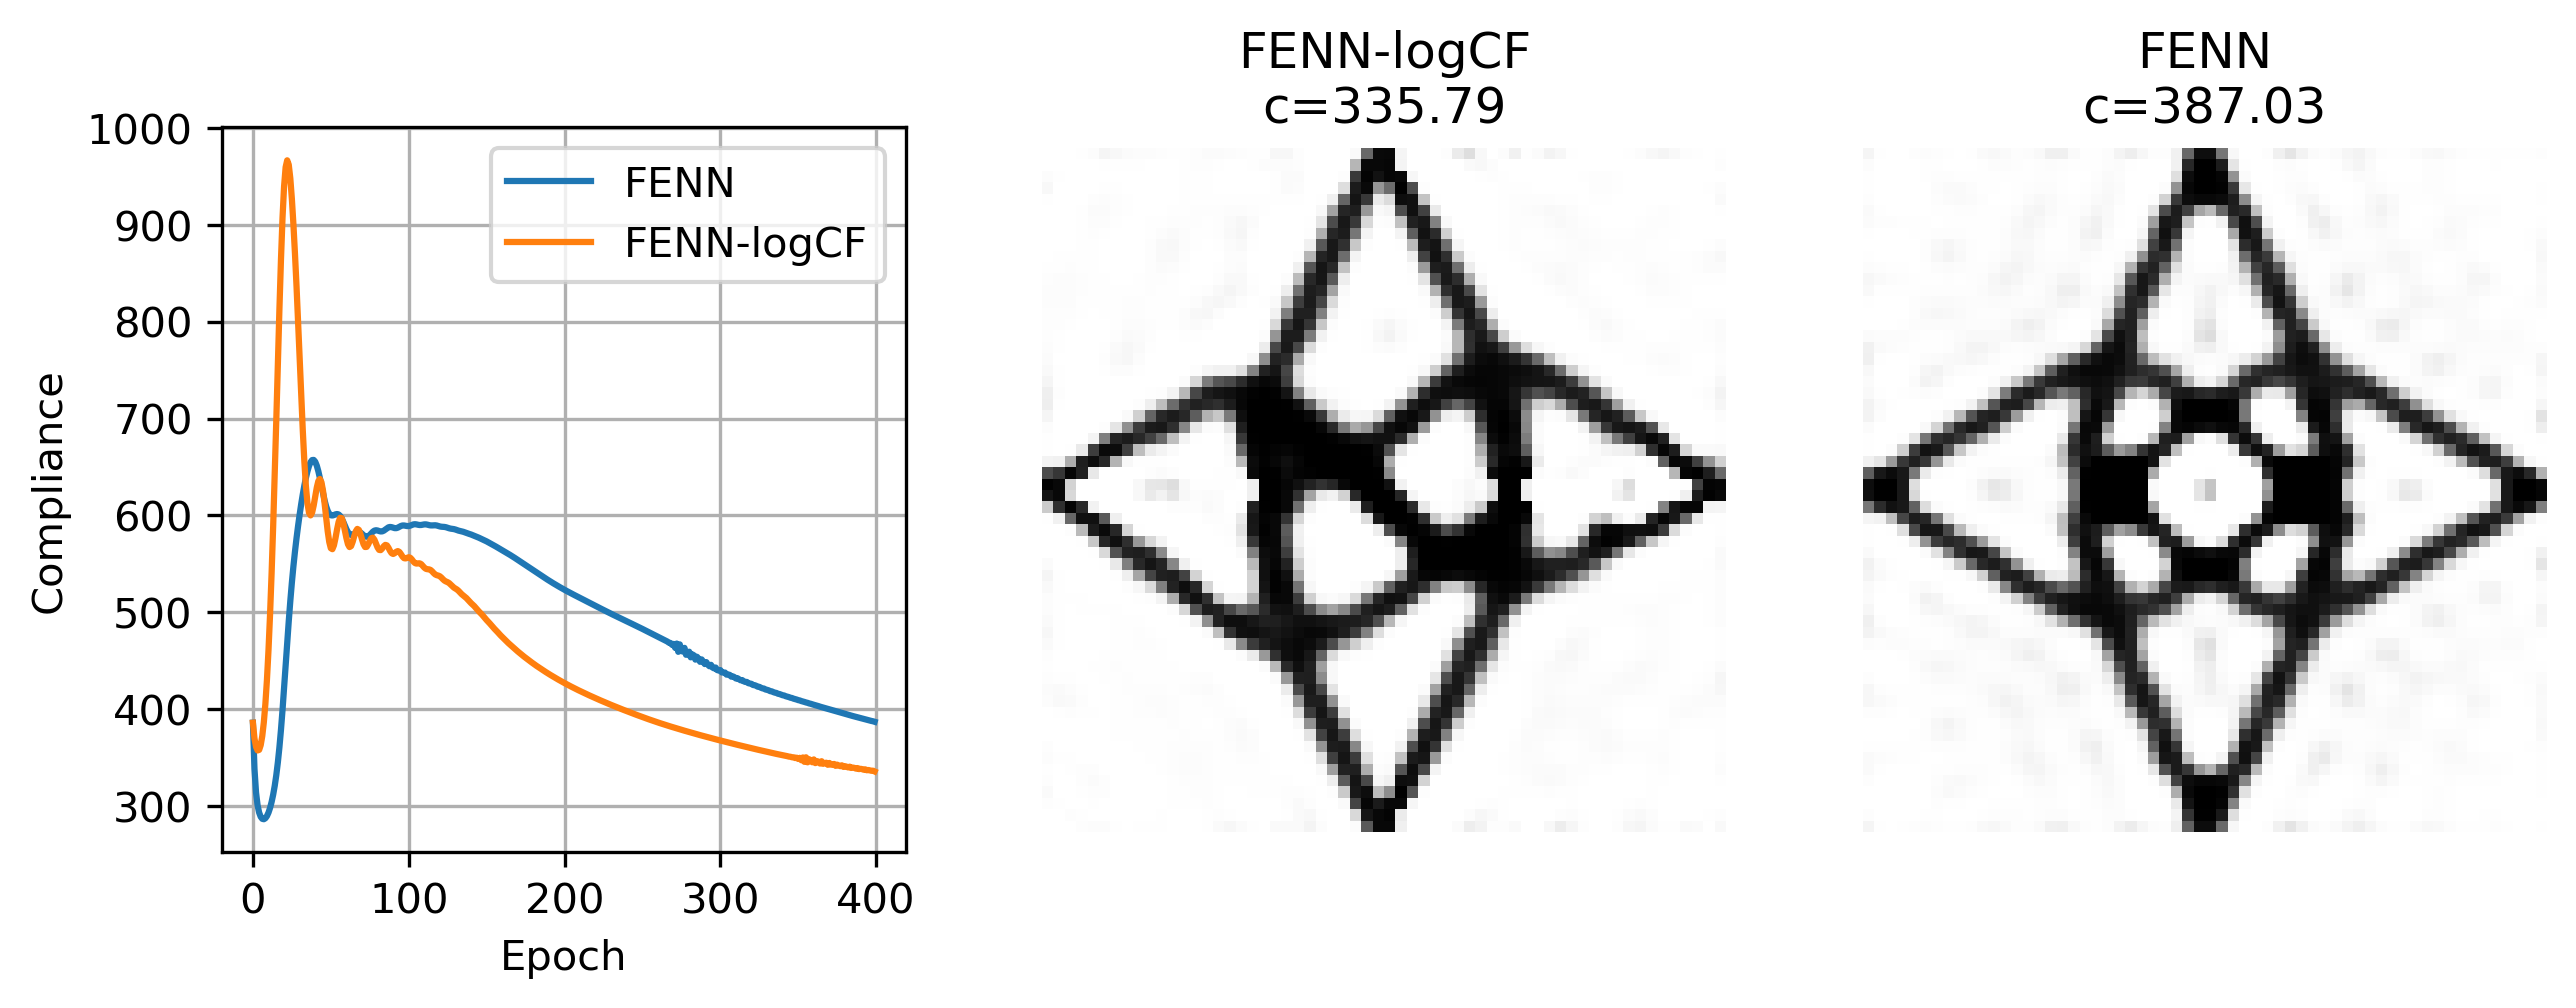

In [8]:
#Clover problem, case 1
problem_h = Clover(0.2)
to_model_h = TO_Net(True)
opt_h = HybridTO(problem_h, to_model_h, True,debug=False)
opt_h.fit_to(400)

problem_v = Clover(0.2)
to_model_v = TO_Net(False)
opt_v = HybridTO(problem_v, to_model_v,False,debug=False)
opt_v.fit_to(400)

plot_conv(opt_v,opt_h,"pic_hist_case1.png")

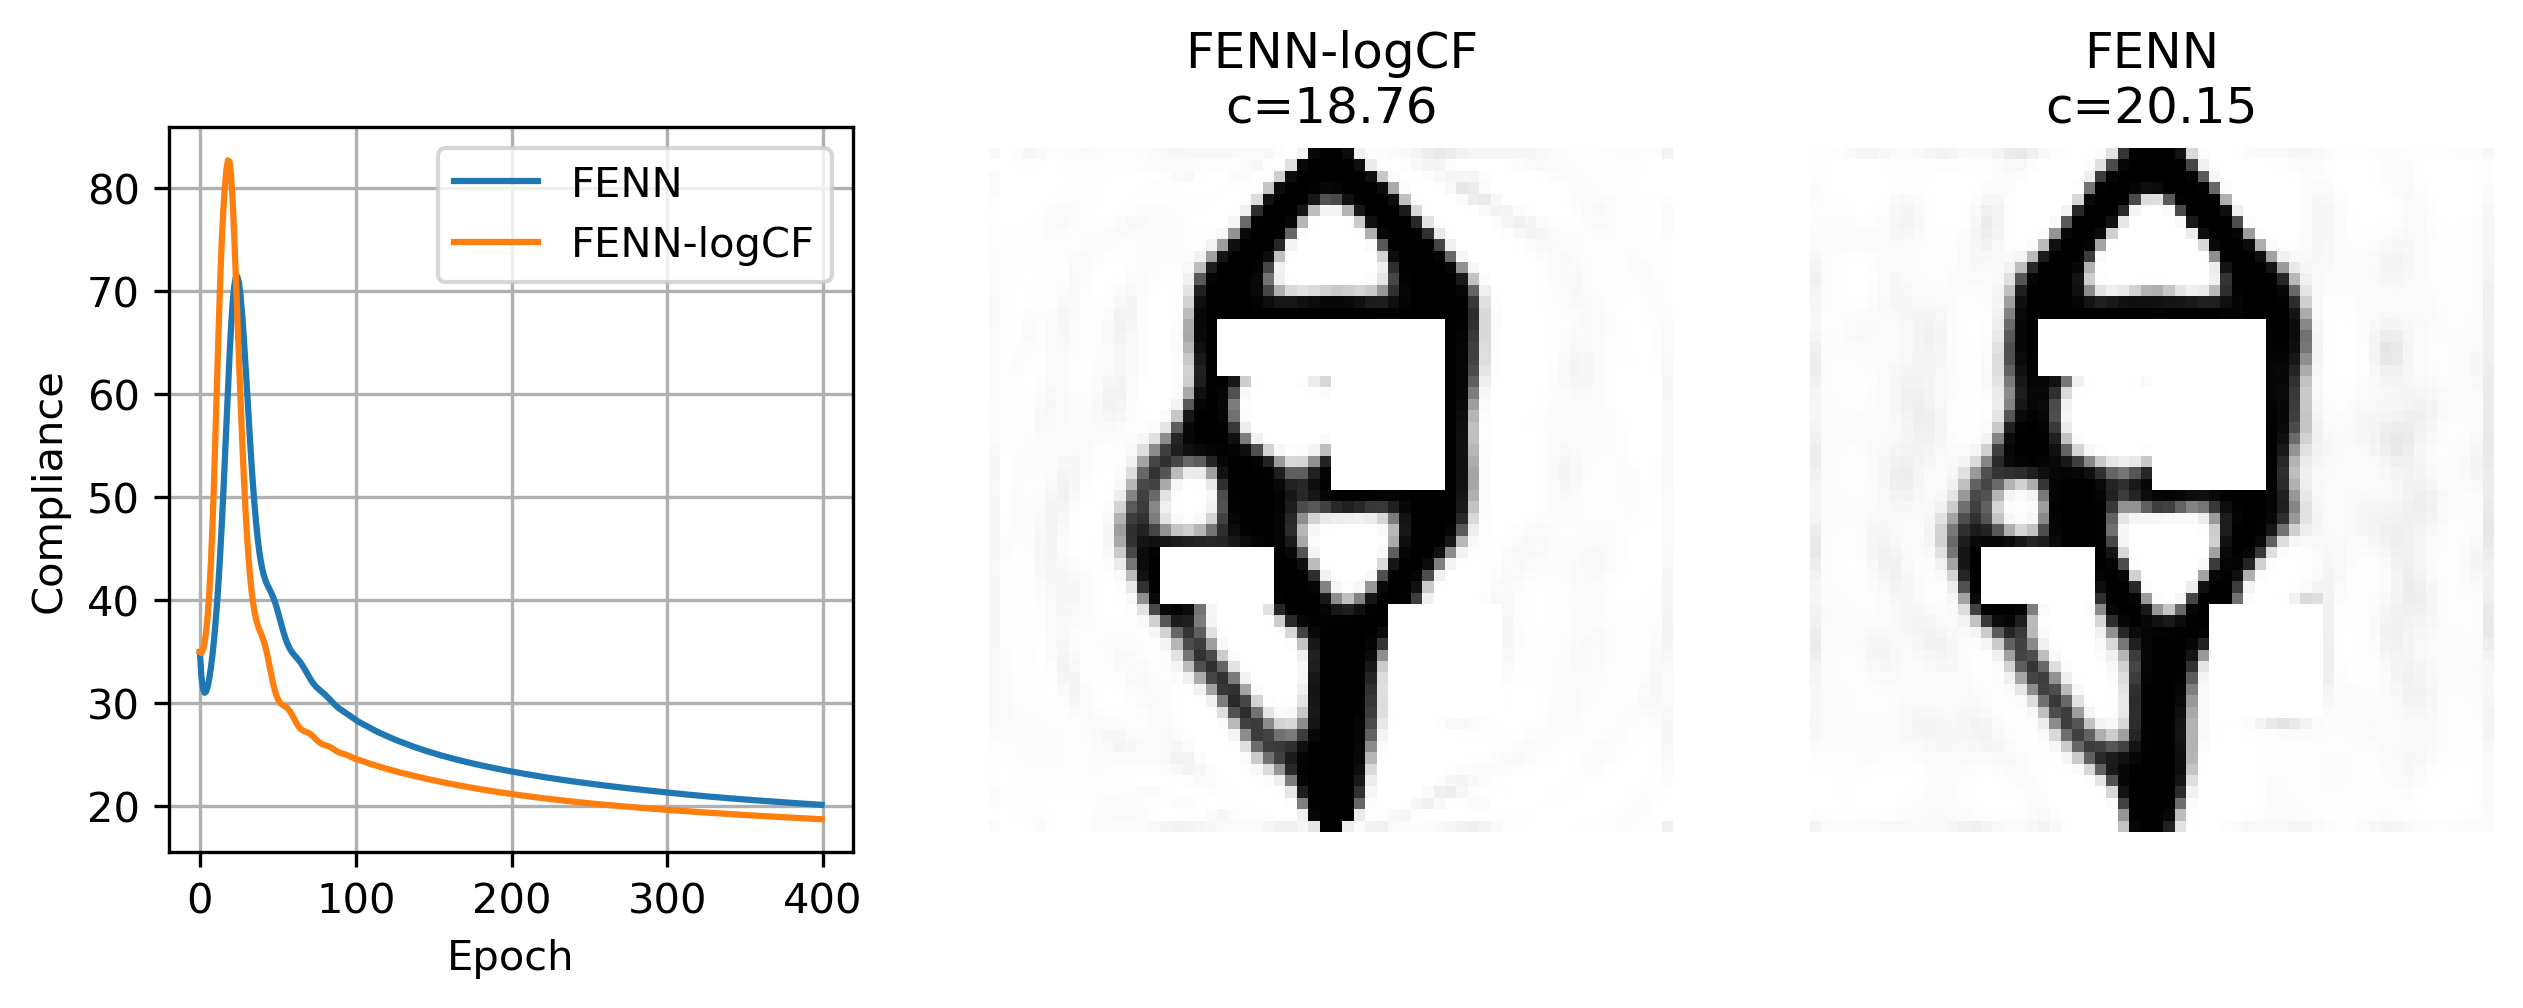

In [9]:
#Many blocks problem, case 2
problem_h = ManyBlocks(0.2)
to_model_h = TO_Net(True)
opt_h = HybridTO(problem_h, to_model_h, True,debug=False)
opt_h.fit_to(400)

problem_v = ManyBlocks(0.2)
to_model_v = TO_Net(False)
opt_v = HybridTO(problem_v, to_model_v,False,debug=False)
opt_v.fit_to(400)

plot_conv(opt_v,opt_h,"pic_hist_case2.png")

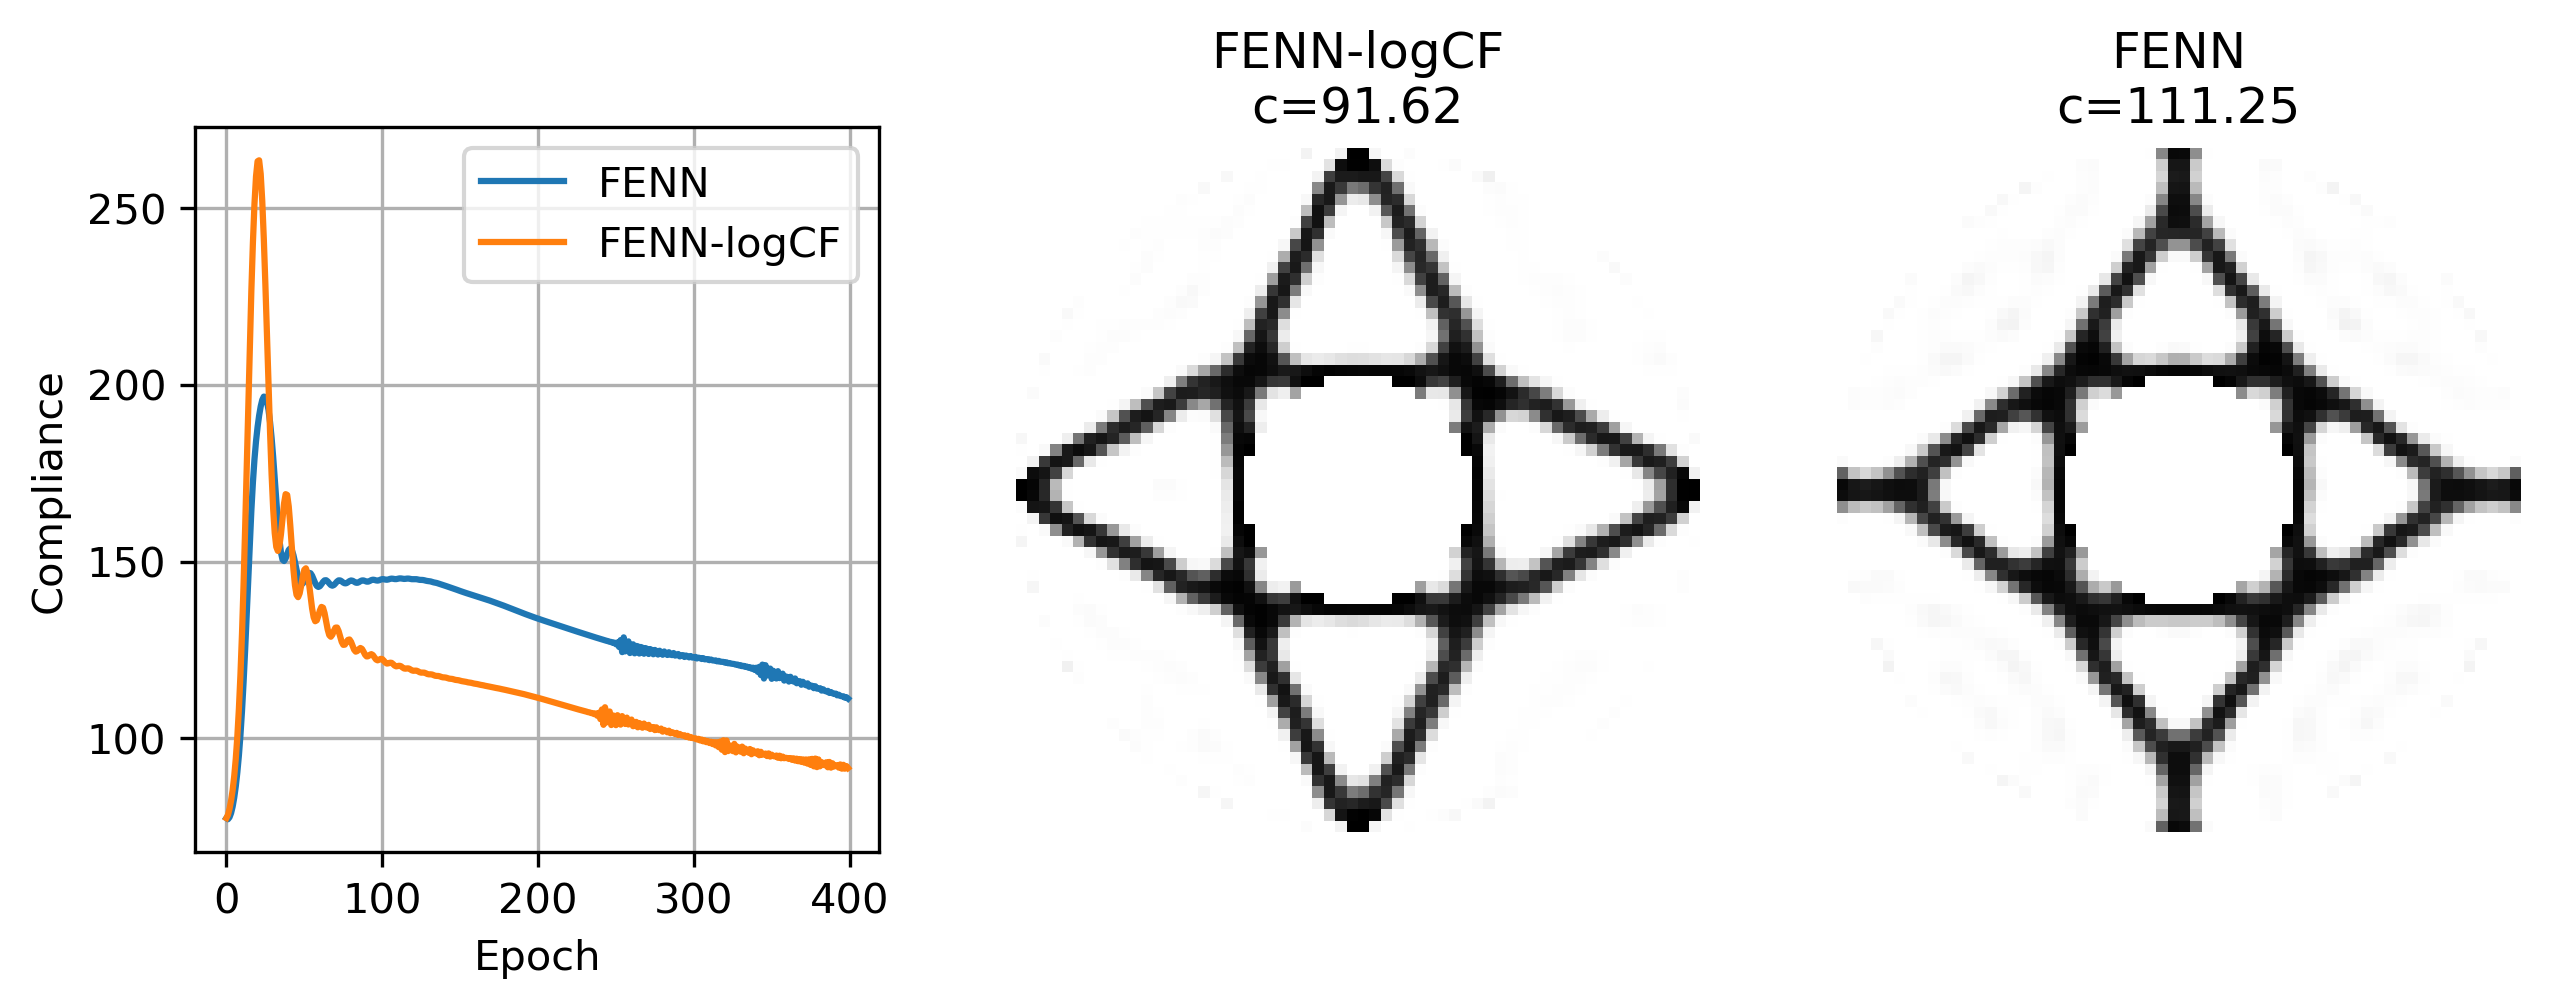

In [10]:
#Wheel problem, case 3 
problem_h = Wheel(0.2)
to_model_h = TO_Net(True)
opt_h = HybridTO(problem_h, to_model_h, True,debug=False)
opt_h.fit_to(400)

problem_v = Wheel(0.2)
to_model_v = TO_Net(False)
opt_v = HybridTO(problem_v, to_model_v,False,debug=False)
opt_v.fit_to(400)

plot_conv(opt_v,opt_h,"pic_hist_case3.png")


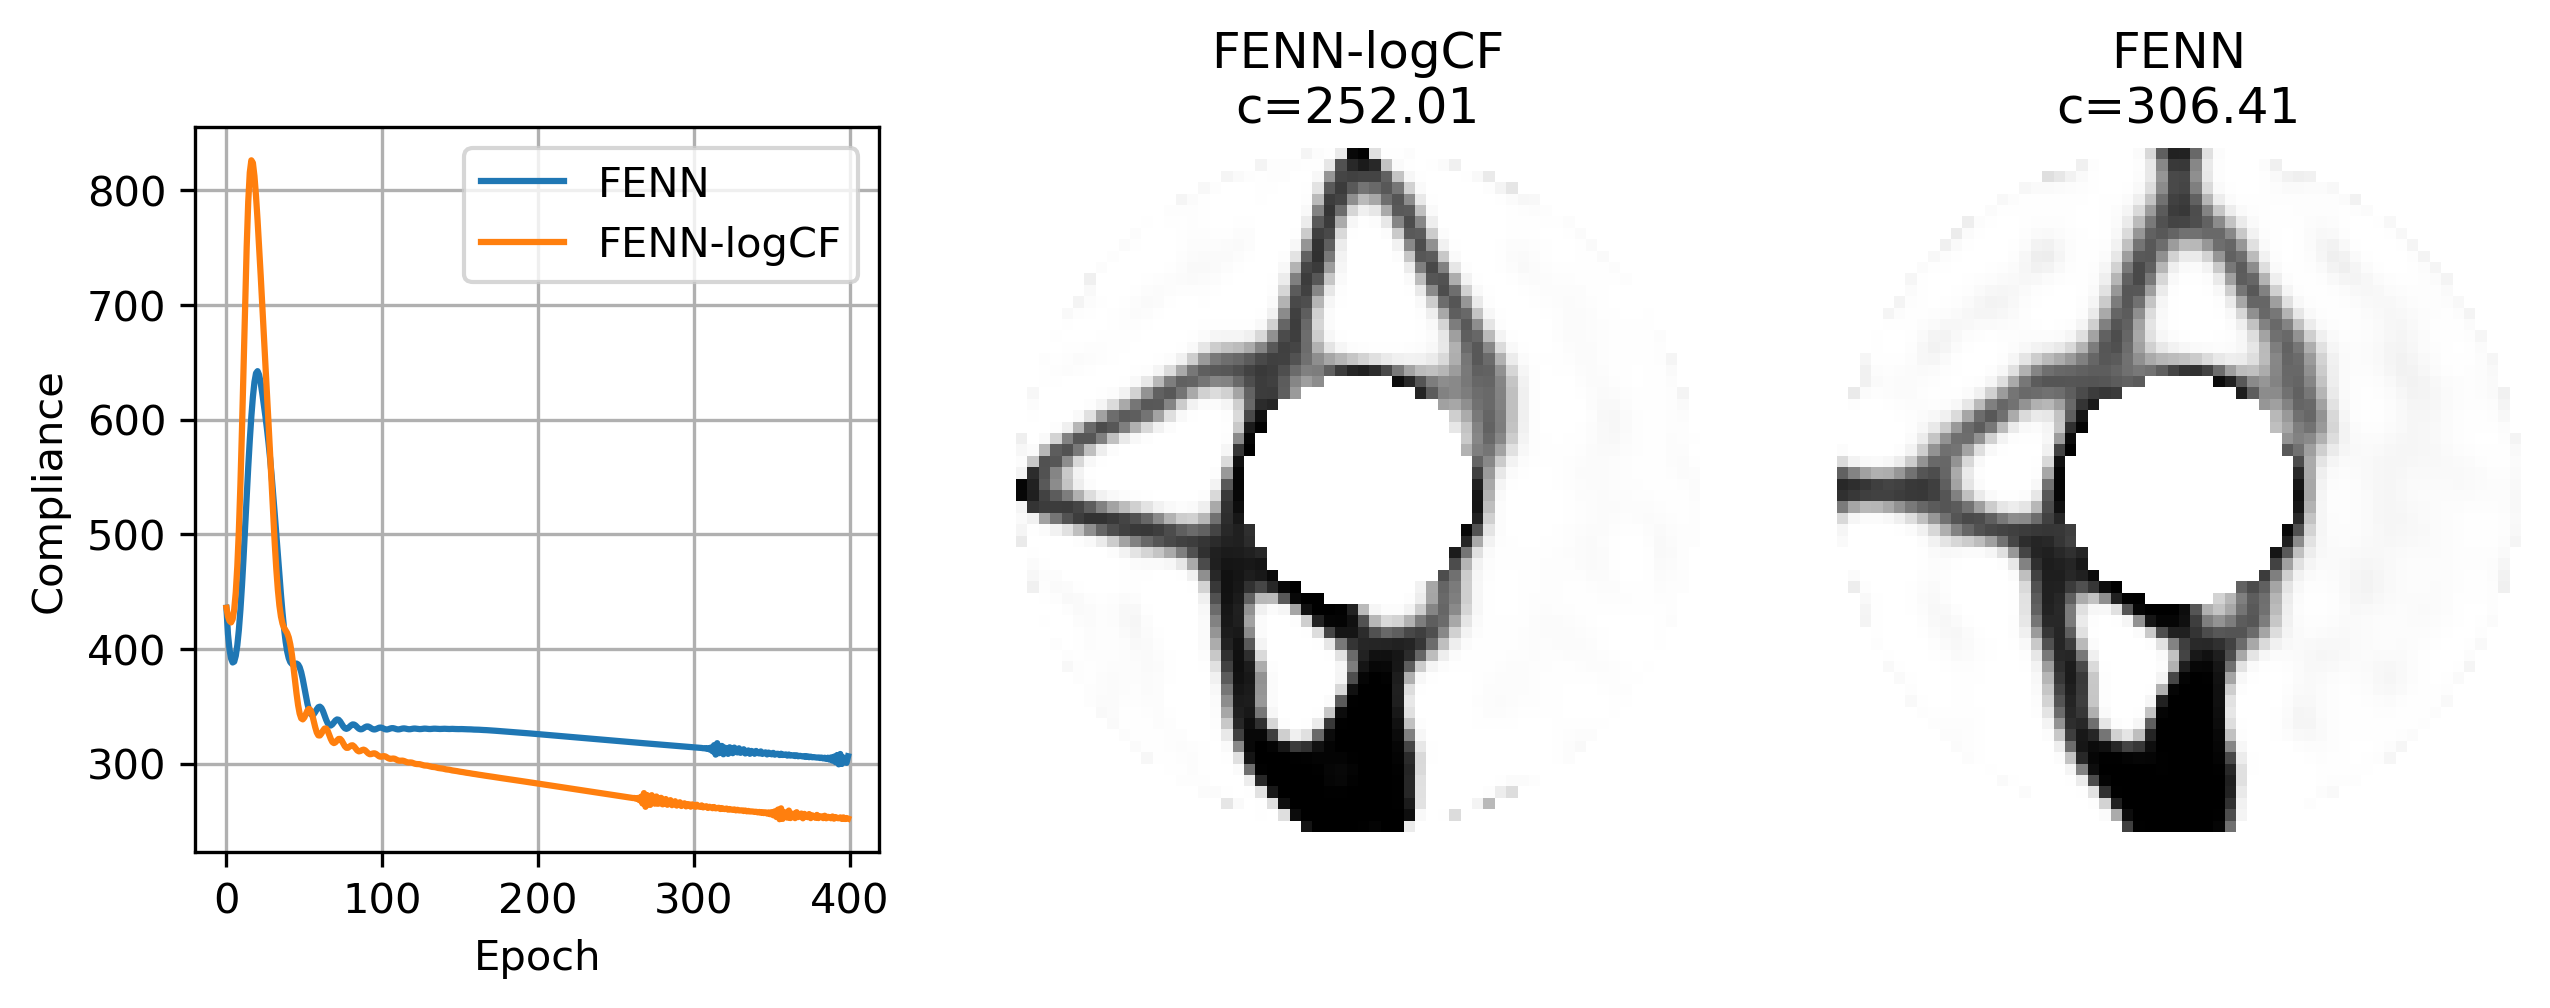

In [11]:
#Asymmetric Wheel problem, case 4
problem_h = WheelAsym(0.2)
to_model_h = TO_Net(True)
opt_h = HybridTO(problem_h, to_model_h, True,debug=False)
opt_h.fit_to(400)

problem_v = WheelAsym(0.2)
to_model_v = TO_Net(False)
opt_v = HybridTO(problem_v, to_model_v,False,debug=False)
opt_v.fit_to(400)

plot_conv(opt_v,opt_h,"pic_hist_case4.png")


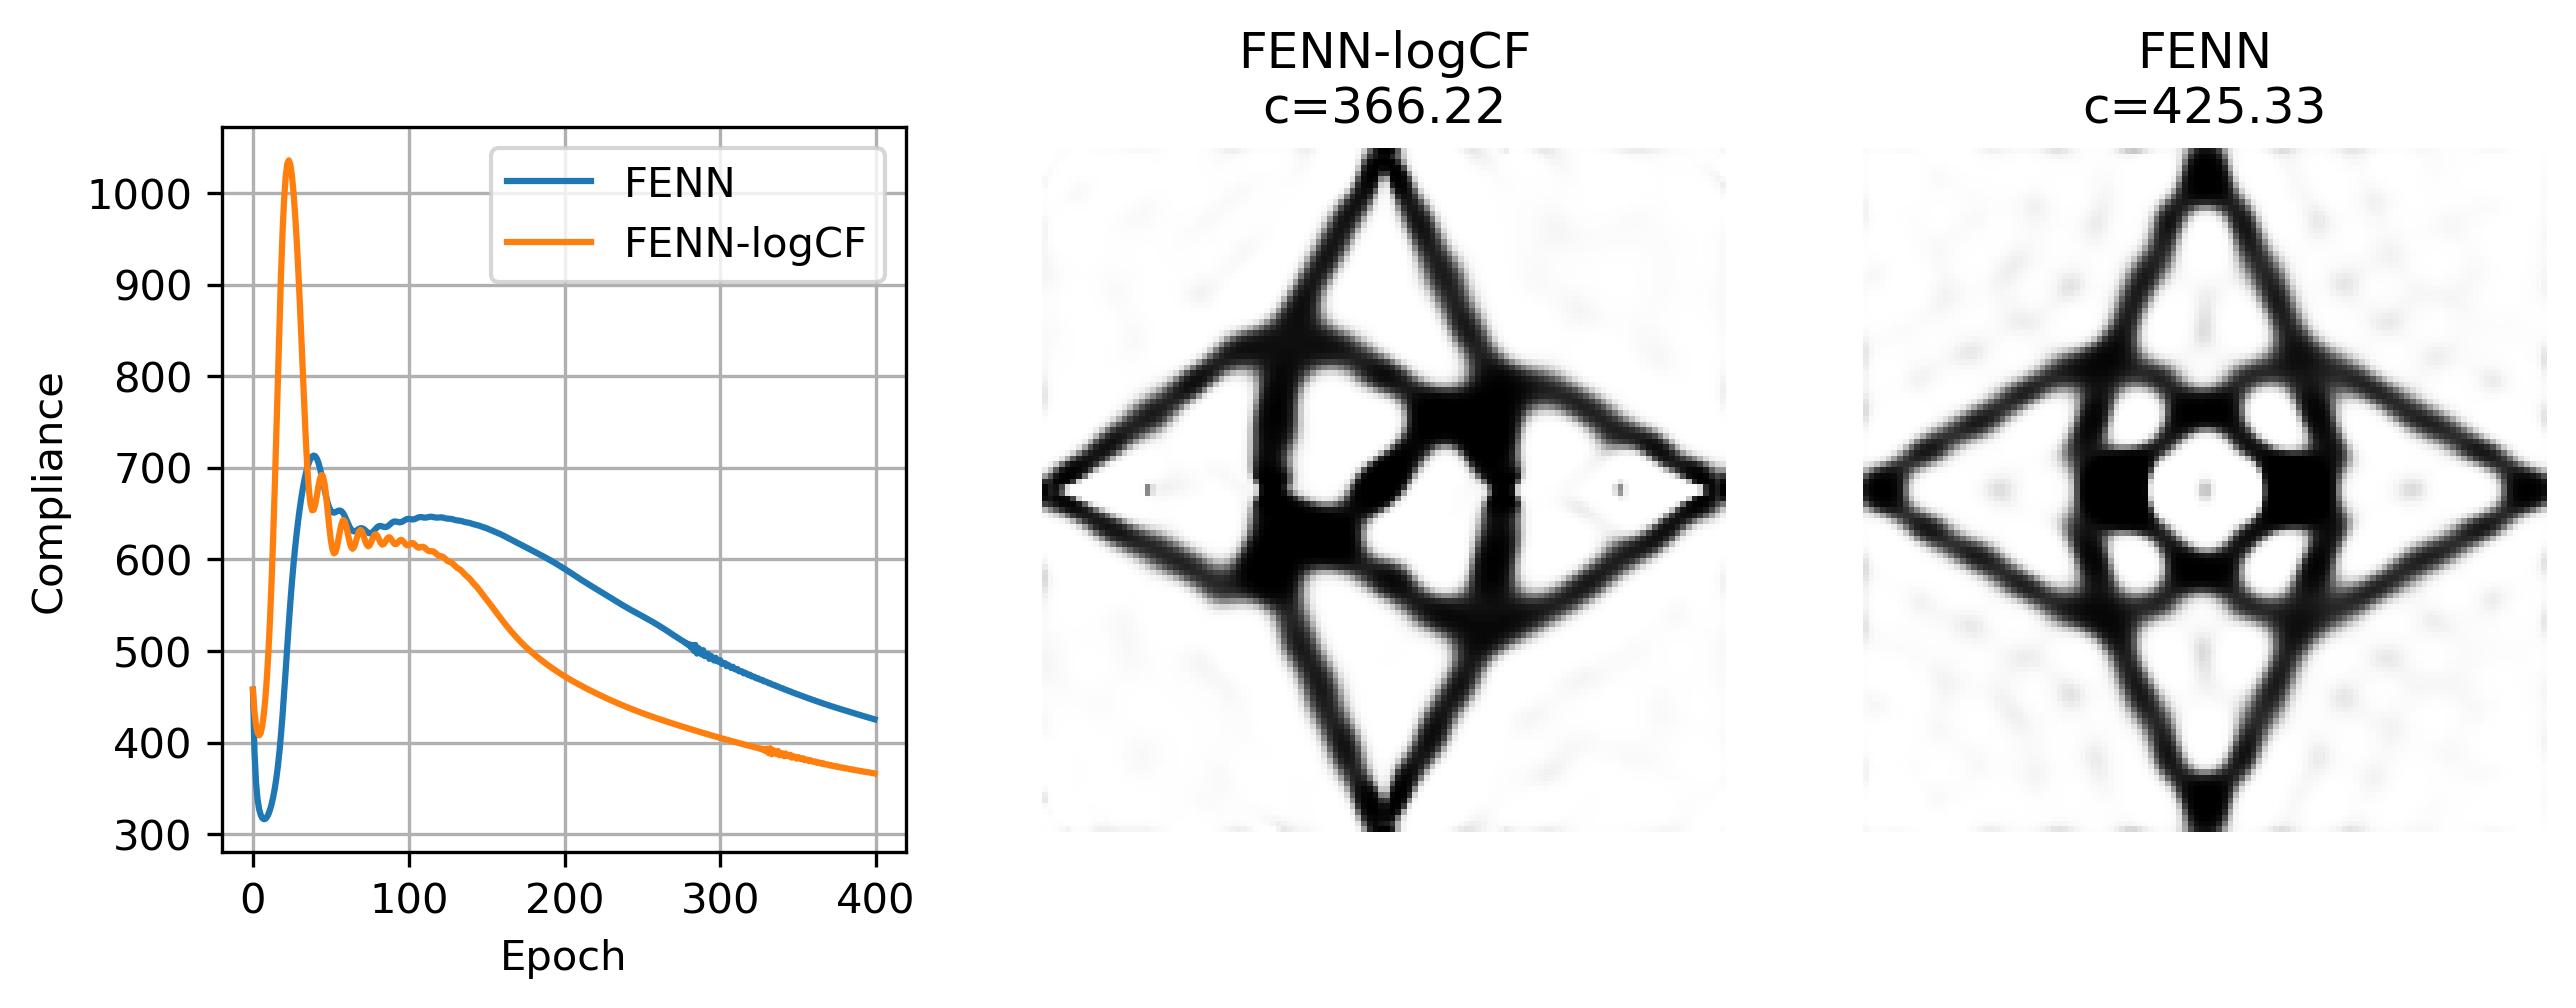

In [13]:
#Clover scaled to 200 percent
problem_h = CloverScaling(120,120,0.2)
to_model_h = TO_Net(True)
opt_h = HybridTO(problem_h, to_model_h, True,False)
opt_h.fit_to(400)

problem_v = CloverScaling(120,120,0.2)
to_model_v = TO_Net(False)
opt_v = HybridTO(problem_v, to_model_v,False,False)
opt_v.fit_to(400)
plot_conv(opt_v,opt_h,"pic_hist_case1_ss.png")

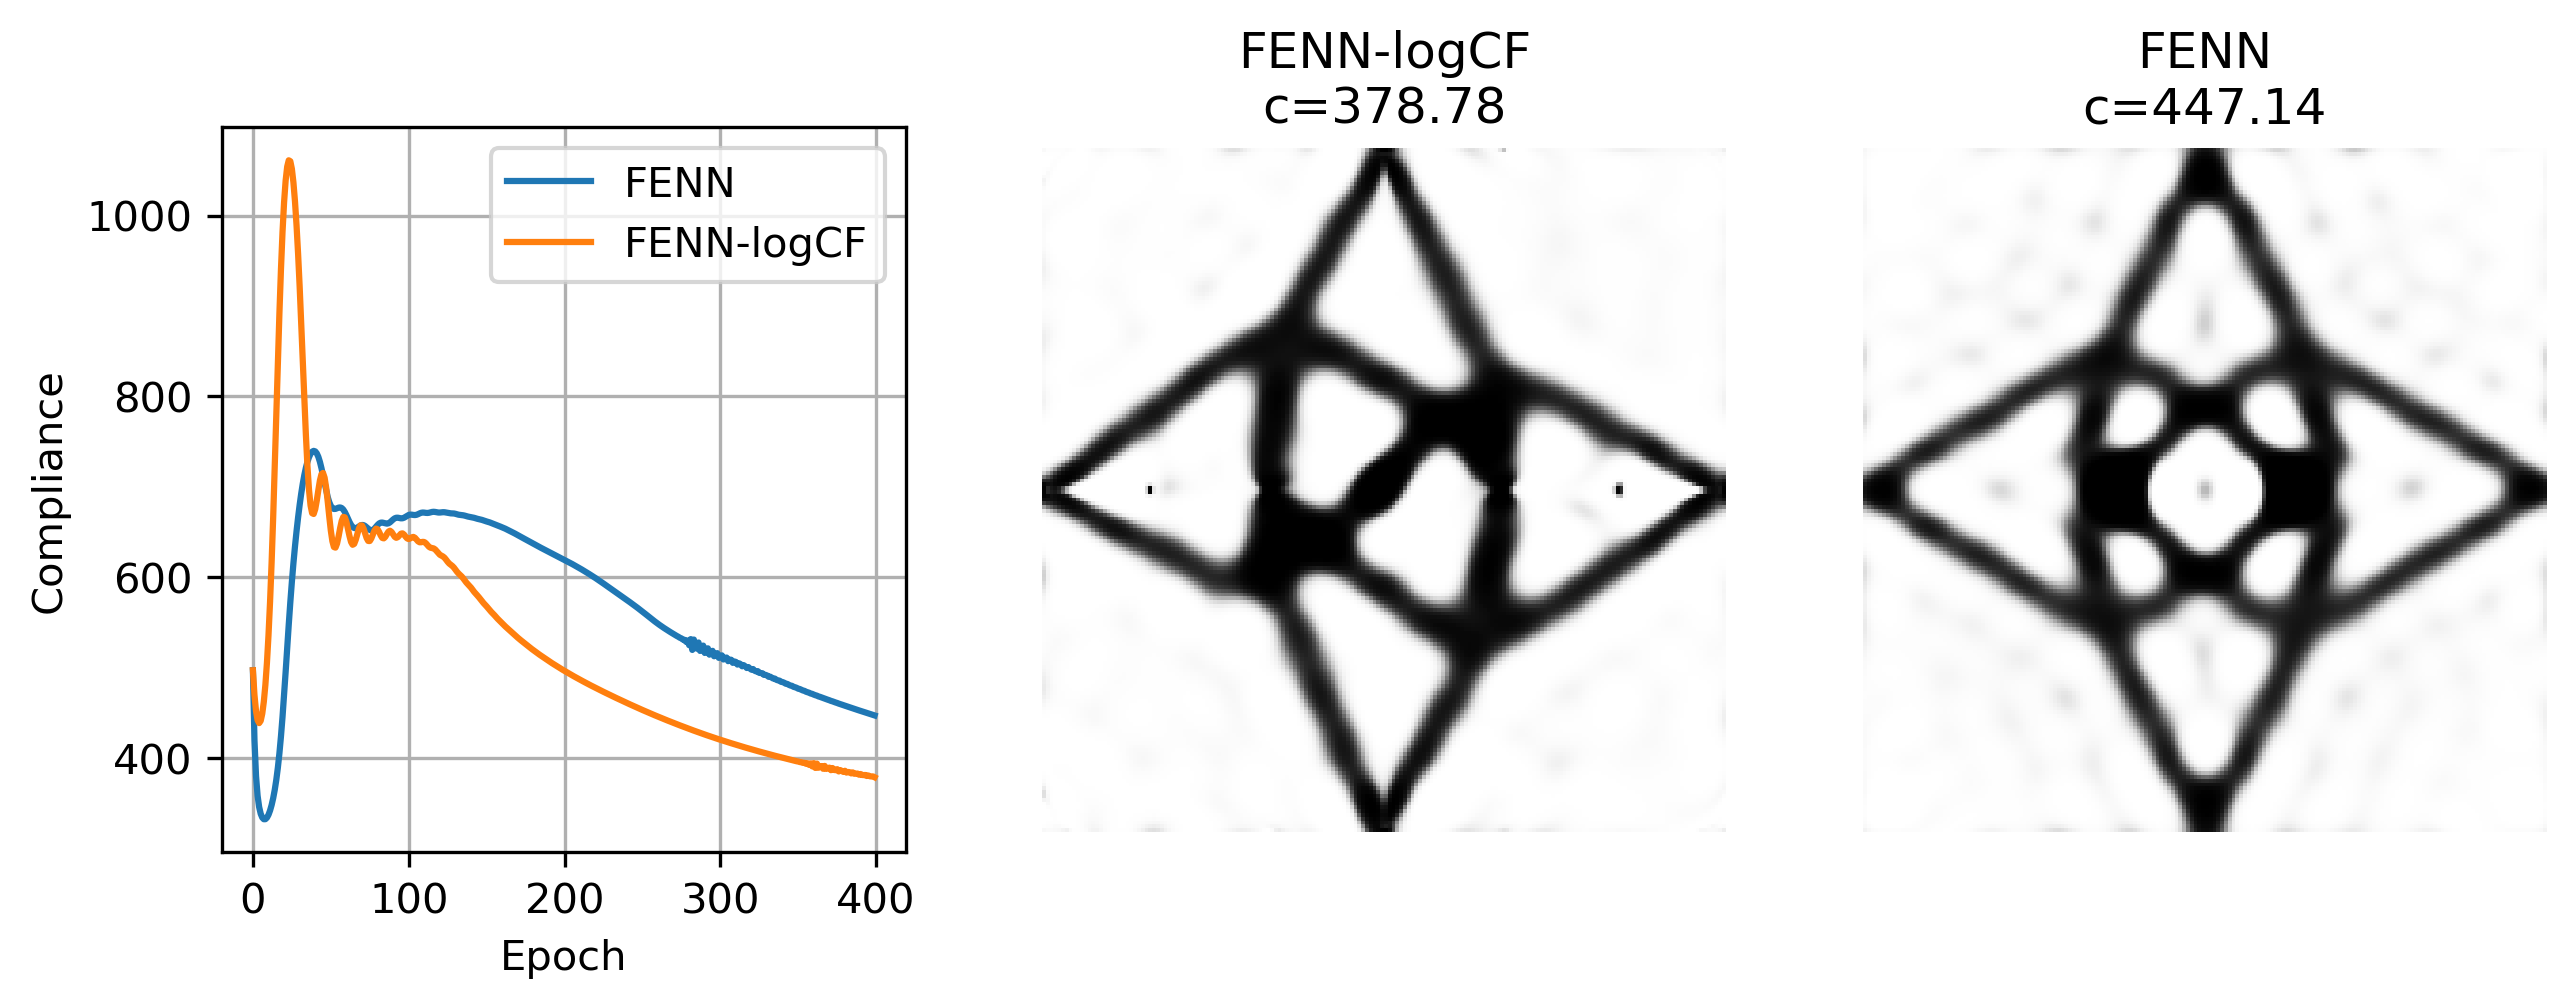

In [14]:
#Clover scaled to 300 percent
problem_h = CloverScaling(180,180,0.2)
to_model_h = TO_Net(True)
opt_h = HybridTO(problem_h, to_model_h, True,False)
opt_h.fit_to(400)

problem_v = CloverScaling(180,180,0.2)
to_model_v = TO_Net(False)
opt_v = HybridTO(problem_v, to_model_v,False,False)
opt_v.fit_to(400)
plot_conv(opt_v,opt_h,"pic_hist_case1_sss.png")